In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEst,max_norm,ApproxDAP
from time import time
from controllers import SafeDAP
from scipy.linalg import sqrtm
%load_ext autoreload
%autoreload 2

# Find a highly stable spring-mass system

Spectral radius of A: 0.9505484720593408 0.2832713102039849 0.9929031536769223
Step 0
Step 100
Step 0
Step 100


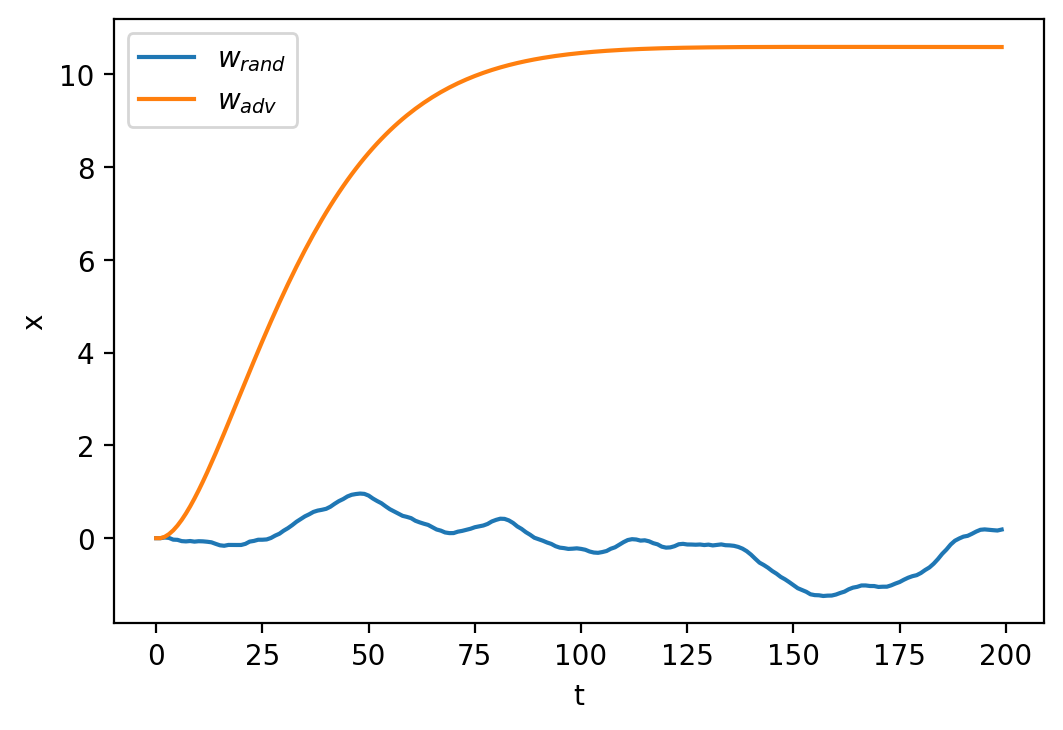

In [2]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.1
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [9]:
x_0 = np.array([0,0]).reshape(-1,1)
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l)

A = env.A
B = env.B
H = 20 # Look back length

eta_bar = 0.4 # The magnitude of exploration noise.


# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.



# Inputs to SafeDAP


Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([4,6.0,4,6.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([6,6])

w_max = env.w_max# w_max should be less than env.w_max for the problem to stay feasible.


env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0



# # Pre-run steps 

x_hist = []
u_hist = []
w_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 400
resolve_per_steps = 20
pre_run_steps = 20
theta_hist = []

# main loop
for _ in range(time_steps):
    x = env.state()
    x_hist.append(x)
    if _<pre_run_steps:
        u = (np.random.rand()-0.5)*2*eta_bar
    else:
        if _%resolve_per_steps==0:
            A_hat,B_hat,r = ModelEst(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist).reshape(-1,u_dim),stability_gap=0.04)

            M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)
            
            theta_hist.append((np.array(A_hat),np.array(B_hat)))
            
        if any([m is None for m in M]):# The solver does not return a feasible solution
            u = (np.random.rand()-0.5)*2*eta_bar
            
#             print(np.linalg.norm(A-A_hat),np.max(np.abs(np.linalg.eigvals(A_hat))))
            print('no sol')
        else:
            u = ApproxDAP(M,w_hist,eta_bar)

    env.step(u)
    u_hist.append(u)
    
    if len(theta_hist)>0:
        w_hat = env.state()-A_hat.dot(x)-B_hat.dot(u)
#         w_hat[w_hat>w_max] = w_max
#         w_hat[w_hat<-w_max] = -w_max 
        w_hist.append(np.array(w_hat)) 
 
#         w_hist.append(env.state()-A_hat.dot(x_hist[-1])-B_hat.dot(u_hist[-1]))
#     print(w_hist[-1])
    
    if _%100 == 0:
        print('Step',_)
        
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

x_no_control_hist = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_no_control_hist.append(x)
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100
Step 200
Step 300
Step 0
Step 100
Step 200
Step 300


In [4]:
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0
# # Pre-run steps 

x_true_hist = []
u_true_hist = []
w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 400
pre_run_steps = 0

# M,Phi = safeDapSolver.solve(A_final,B,H,e_x=e_x,e_u=e_u)
M,Phi = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
# M,Phi = safeDapSolver.solve(theta_hist[-1][0],theta_hist[-1][1],H,e_x=e_x,e_u=e_u)
     
# main loop
for _ in range(time_steps):
    x = env.state()
    x_true_hist.append(x)
    if _<pre_run_steps:
        u = (np.random.rand()-0.5)*2*eta_bar
    else:
        u = ApproxDAP(M,w_true_hist,eta_bar)

    env.step(u)
    u_true_hist.append(u)
    
    w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100
Step 200
Step 300


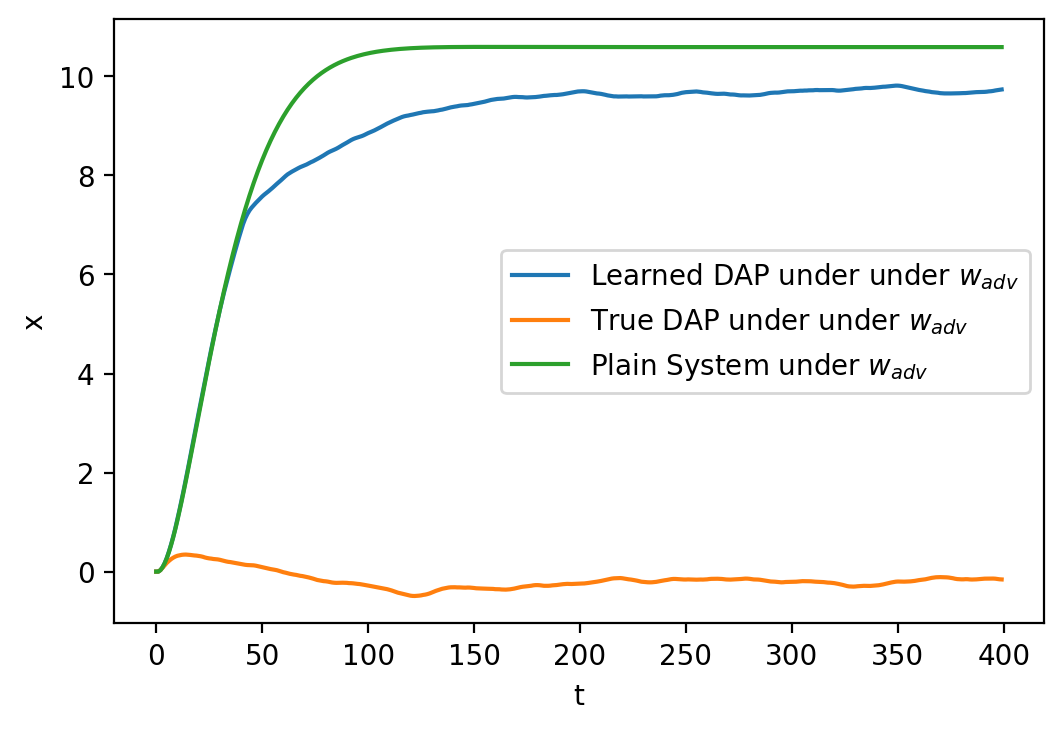

In [10]:
plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,0],label=r'Learned DAP under under $w_{adv}$')
plt.plot(np.array(x_true_hist)[:,0],label=r'True DAP under under $w_{adv}$')

plt.plot(np.array(x_no_control_hist)[:,0],label=r'Plain System under $w_{adv}$')

plt.xlabel('t')


plt.ylabel('x')
plt.legend()


Text(0.5, 0, '$t$')

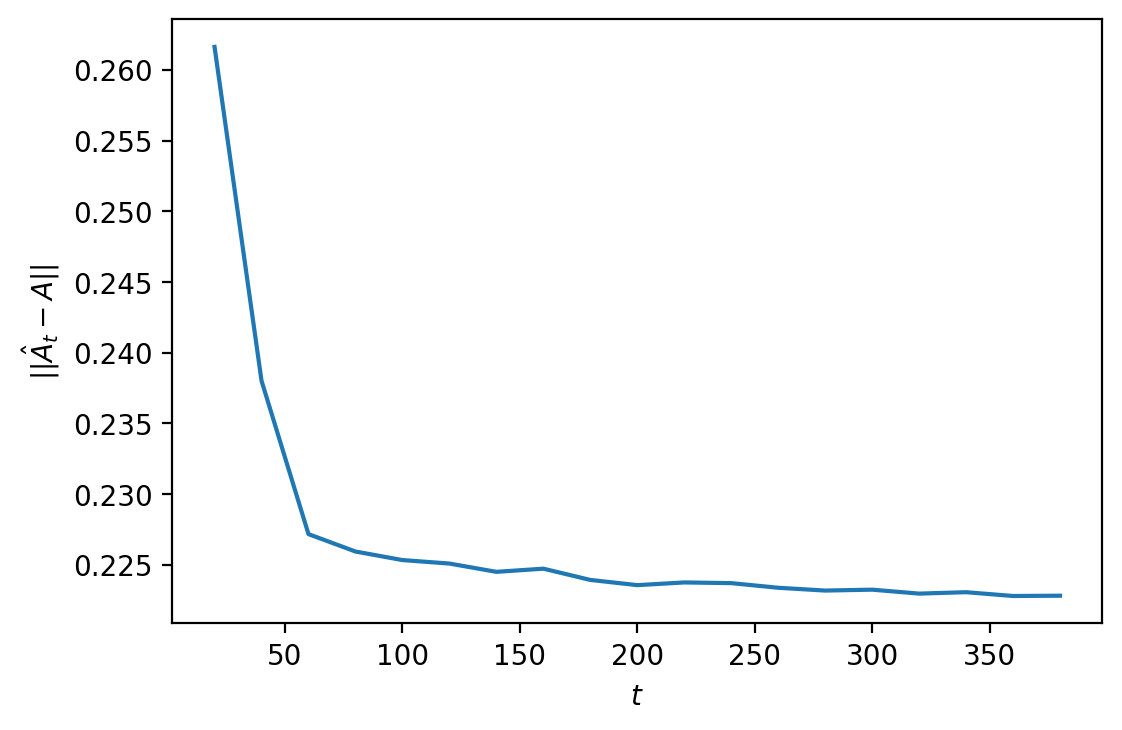

In [6]:
A_hist = np.array([m[0] for m in theta_hist])
A_diff = np.linalg.norm(A-A_hist,axis=(-1,-2))

plt.figure(dpi=200)
plt.plot(np.arange(20,400,20),A_diff)
plt.ylabel(r'$||\hat{A}_t-A||$')
plt.xlabel(r'$t$')

Text(0.5, 0, '$t$')

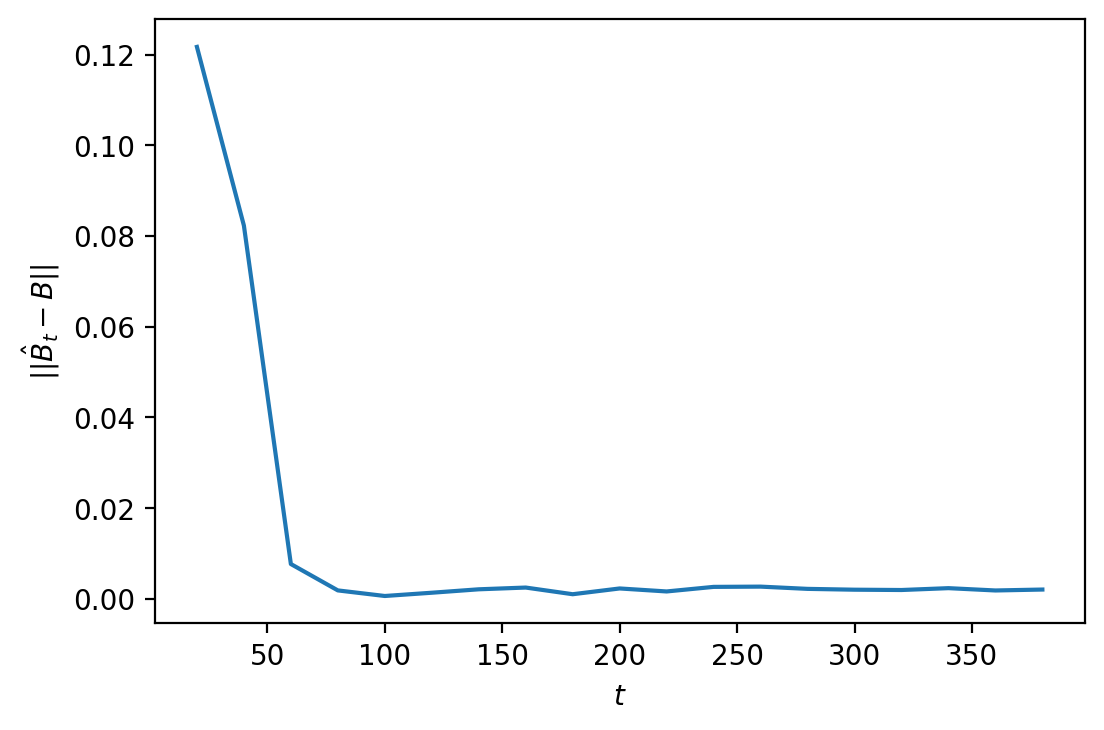

In [8]:
B_hist = np.array([m[1] for m in theta_hist])
B_diff = np.linalg.norm(B-B_hist,axis=(-1,-2))

plt.figure(dpi=200)
plt.plot(np.arange(20,400,20),B_diff)
plt.ylabel(r'$||\hat{B}_t-B||$')
plt.xlabel(r'$t$')

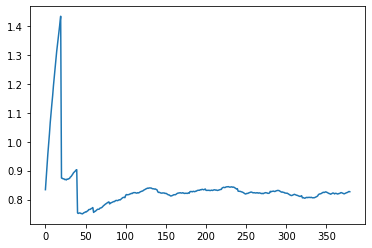

In [6]:
plt.plot(np.array(w_hist[10*H:]).reshape(-1,2)[:,0])

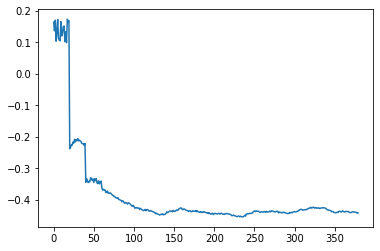

In [7]:
plt.plot(np.array(w_hist[10*H:]).reshape(-1,2)[:,1])

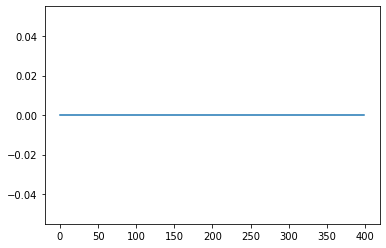

In [8]:
plt.plot(np.array(w_true_hist[10*H:]).reshape(-1,2)[:,0])

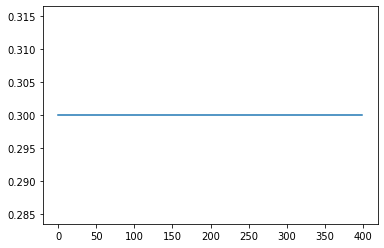

In [9]:
plt.plot(np.array(w_true_hist[10*H:]).reshape(-1,2)[:,1])